# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
# when running in Udacity workspace
# !pip -q install ./python

In [1]:
from maddpg_agent import Agent
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
from unityagents import UnityEnvironment

%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
## when running locally
env = UnityEnvironment(file_name='Tennis.app')


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [13]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
SOLVED_SCORE = 0.5
CONSEC_EPISODES = 100
PRINT_EVERY = 10
ADD_NOISE = True

In [8]:
# MADDPG function

def maddpg(n_episodes=2000, max_t=1000, train_mode=True):
    """Multi-Agent Deep Deterministic Policy Gradient (MADDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        train_mode (bool)     : if 'True' set environment to training mode

    """
    scores_window = deque(maxlen=CONSEC_EPISODES)
    scores_all = []
    moving_average = []
    best_score = -np.inf
    best_episode = 0
    already_solved = False    

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]         # reset the environment
        states = np.reshape(env_info.vector_observations, (1,48)) # get states and combine them
        agent_0.reset()
        agent_1.reset()
        scores = np.zeros(num_agents)
        while True:
            actions = get_actions(states, ADD_NOISE)           # choose agent actions and combine them
            env_info = env.step(actions)[brain_name]           # send both agents' actions together to the environment
            next_states = np.reshape(env_info.vector_observations, (1, 48)) # combine the agent next states
            rewards = env_info.rewards                         # get reward
            done = env_info.local_done                         # see if episode finished
            agent_0.step(states, actions, rewards[0], next_states, done, 0) # agent 1 learns
            agent_1.step(states, actions, rewards[1], next_states, done, 1) # agent 2 learns
            scores += np.max(rewards)                          # update the score for each agent
            states = next_states                               # roll over states to next time step
            if np.any(done):                                   # exit loop if episode finished
                break

        ep_best_score = np.max(scores)
        scores_window.append(ep_best_score)
        scores_all.append(ep_best_score)
        moving_average.append(np.mean(scores_window))

        # save best score                        
        if ep_best_score > best_score:
            best_score = ep_best_score
            best_episode = i_episode
        
        # print results
        if i_episode % PRINT_EVERY == 0:
            print('Episodes {:0>4d}-{:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode-PRINT_EVERY, i_episode, np.max(scores_all[-PRINT_EVERY:]), moving_average[-1]))

        # determine if environment is solved and keep best performing models
        if moving_average[-1] >= SOLVED_SCORE:
            if not already_solved:
                print('<-- Environment solved in {:d} episodes! \
                \n<-- Moving Average: {:.3f} over past {:d} episodes'.format(
                    i_episode-CONSEC_EPISODES, moving_average[-1], CONSEC_EPISODES))
                already_solved = True
                # save weights
                torch.save(agent_0.actor_local.state_dict(), 'models/checkpoint_actor_0.pth')
                torch.save(agent_0.critic_local.state_dict(), 'models/checkpoint_critic_0.pth')
                torch.save(agent_1.actor_local.state_dict(), 'models/checkpoint_actor_1.pth')
                torch.save(agent_1.critic_local.state_dict(), 'models/checkpoint_critic_1.pth')
            elif ep_best_score >= best_score:
                print('<-- Best episode so far!\
                \nEpisode {:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode, ep_best_score, moving_average[-1]))
                # save weights
                torch.save(agent_0.actor_local.state_dict(), 'models/checkpoint_actor_0.pth')
                torch.save(agent_0.critic_local.state_dict(), 'models/checkpoint_critic_0.pth')
                torch.save(agent_1.actor_local.state_dict(), 'models/checkpoint_actor_1.pth')
                torch.save(agent_1.critic_local.state_dict(), 'models/checkpoint_critic_1.pth')
            elif (i_episode-best_episode) >= 200:
                # stop training if model stops converging
                print('<-- Training stopped. Best score not matched or exceeded for 200 episodes')
                break
            else:
                continue
            
    return scores_all, moving_average

In [5]:
def get_actions(states, add_noise):
    '''gets actions for each agent and then combines them into one array'''
    action_0 = agent_0.act(states, add_noise)    # agent 0 chooses an action
    action_1 = agent_1.act(states, add_noise)    # agent 1 chooses an action
    return np.concatenate((action_0, action_1), axis=0).flatten()

In [10]:
# initialize agents
agent_0 = Agent(state_size, action_size, num_agents=1, random_seed=0)
agent_1 = Agent(state_size, action_size, num_agents=1, random_seed=0)

### Best Model

In [8]:
# run the training loop

# BUFFER_SIZE = int(1e6)  # replay buffer size
# BATCH_SIZE = 128        # minibatch size
# LR_ACTOR = 1e-3         # learning rate of the actor
# LR_CRITIC = 1e-3        # learning rate of the critic
# WEIGHT_DECAY = 0        # L2 weight decay
# LEARN_EVERY = 1         # learning timestep interval
# LEARN_NUM = 1           # number of learning passes
# GAMMA = 0.99            # discount factor
# TAU = 7e-2              # for soft update of target parameters
# OU_SIGMA = 0.2          # Ornstein-Uhlenbeck noise parameter, volatility
# OU_THETA = 0.12         # Ornstein-Uhlenbeck noise parameter, speed of mean reversion
# EPS_START = 5.5         # initial value for epsilon in noise decay process in Agent.act()
# EPS_EP_END = 250        # episode to end the noise decay process
# EPS_FINAL = 0           # final value for epsilon after decay

scores, avgs = maddpg()

Episodes 0000-0010	Max Reward: 0.100	Moving Average: 0.040
Episodes 0010-0020	Max Reward: 0.100	Moving Average: 0.025
Episodes 0020-0030	Max Reward: 0.000	Moving Average: 0.017
Episodes 0030-0040	Max Reward: 0.100	Moving Average: 0.018
Episodes 0040-0050	Max Reward: 0.100	Moving Average: 0.016
Episodes 0050-0060	Max Reward: 0.100	Moving Average: 0.017
Episodes 0060-0070	Max Reward: 0.100	Moving Average: 0.019
Episodes 0070-0080	Max Reward: 0.100	Moving Average: 0.020
Episodes 0080-0090	Max Reward: 0.100	Moving Average: 0.026
Episodes 0090-0100	Max Reward: 0.100	Moving Average: 0.026
Episodes 0100-0110	Max Reward: 0.100	Moving Average: 0.023
Episodes 0110-0120	Max Reward: 0.100	Moving Average: 0.026
Episodes 0120-0130	Max Reward: 0.100	Moving Average: 0.029
Episodes 0130-0140	Max Reward: 0.100	Moving Average: 0.034
Episodes 0140-0150	Max Reward: 0.100	Moving Average: 0.042
Episodes 0150-0160	Max Reward: 0.200	Moving Average: 0.046
Episodes 0160-0170	Max Reward: 0.100	Moving Average: 0.0

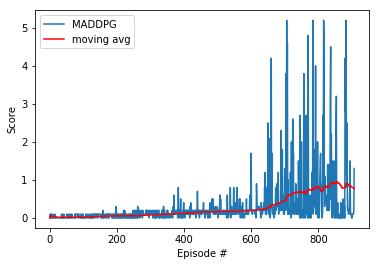

In [9]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='MADDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='moving avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

### Second Best Model

In [11]:
# run the training loop

# BUFFER_SIZE = int(1e6)  # replay buffer size
# BATCH_SIZE = 128        # minibatch size
# LR_ACTOR = 1e-3         # learning rate of the actor
# LR_CRITIC = 1e-3        # learning rate of the critic
# WEIGHT_DECAY = 0        # L2 weight decay
# LEARN_EVERY = 1         # learning timestep interval
# LEARN_NUM = 5           # number of learning passes
# GAMMA = 0.99            # discount factor
# TAU = 8e-3              # for soft update of target parameters
# OU_SIGMA = 0.2          # Ornstein-Uhlenbeck noise parameter, volatility
# OU_THETA = 0.15          # Ornstein-Uhlenbeck noise parameter, speed of mean reversion
# EPS_START = 5.0         # initial value for epsilon in noise decay process in Agent.act()
# EPS_EP_END = 300        # episode to end the noise decay process
# EPS_FINAL = 0           # final value for epsilon after decay

scores, avgs = maddpg()

Episodes 0000-0010	Max Reward: 0.200	Moving Average: 0.030
Episodes 0010-0020	Max Reward: 0.000	Moving Average: 0.015
Episodes 0020-0030	Max Reward: 0.100	Moving Average: 0.020
Episodes 0030-0040	Max Reward: 0.000	Moving Average: 0.015
Episodes 0040-0050	Max Reward: 0.000	Moving Average: 0.012
Episodes 0050-0060	Max Reward: 0.100	Moving Average: 0.012
Episodes 0060-0070	Max Reward: 0.100	Moving Average: 0.013
Episodes 0070-0080	Max Reward: 0.100	Moving Average: 0.013
Episodes 0080-0090	Max Reward: 0.100	Moving Average: 0.012
Episodes 0090-0100	Max Reward: 0.100	Moving Average: 0.014
Episodes 0100-0110	Max Reward: 0.100	Moving Average: 0.012
Episodes 0110-0120	Max Reward: 0.100	Moving Average: 0.016
Episodes 0120-0130	Max Reward: 0.100	Moving Average: 0.014
Episodes 0130-0140	Max Reward: 0.100	Moving Average: 0.015
Episodes 0140-0150	Max Reward: 0.000	Moving Average: 0.015
Episodes 0150-0160	Max Reward: 0.000	Moving Average: 0.014
Episodes 0160-0170	Max Reward: 0.100	Moving Average: 0.0

Episodes 1310-1320	Max Reward: 0.100	Moving Average: 0.239
Episodes 1320-1330	Max Reward: 0.100	Moving Average: 0.211
Episodes 1330-1340	Max Reward: 0.300	Moving Average: 0.206
Episodes 1340-1350	Max Reward: 0.500	Moving Average: 0.189
Episodes 1350-1360	Max Reward: 0.300	Moving Average: 0.143
Episodes 1360-1370	Max Reward: 0.600	Moving Average: 0.125
Episodes 1370-1380	Max Reward: 1.900	Moving Average: 0.138
Episodes 1380-1390	Max Reward: 1.700	Moving Average: 0.178
Episodes 1390-1400	Max Reward: 5.200	Moving Average: 0.277
Episodes 1400-1410	Max Reward: 0.300	Moving Average: 0.280
Episodes 1410-1420	Max Reward: 2.800	Moving Average: 0.318
Episodes 1420-1430	Max Reward: 2.100	Moving Average: 0.361
Episodes 1430-1440	Max Reward: 4.100	Moving Average: 0.424
Episodes 1440-1450	Max Reward: 2.500	Moving Average: 0.479
<-- Training stopped. Best score not matched or exceeded for 200 episodes


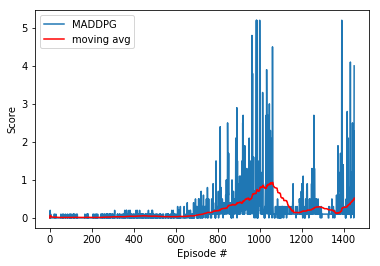

In [12]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='MADDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='moving avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

---
### 5. Test a saved agent

In [6]:
CONSEC_EPISODES = 10
PRINT_EVERY = 1
ADD_NOISE = False

In [7]:
## reinitialize the agents (if needed)
agent_0 = Agent(state_size, action_size, num_agents=1, random_seed=0)
agent_1 = Agent(state_size, action_size, num_agents=1, random_seed=0)

# load the weights from file
agent_0_weights = 'models/best/checkpoint_actor_0.pth'
agent_1_weights = 'models/best/checkpoint_actor_1.pth'
agent_0.actor_local.load_state_dict(torch.load(agent_0_weights))
agent_1.actor_local.load_state_dict(torch.load(agent_1_weights))     

In [8]:
def test(n_episodes=10, max_t=1000, train_mode=False):

    scores_window = deque(maxlen=CONSEC_EPISODES)
    scores_all = []
    moving_average = []  

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]         # reset the environment
        states = np.reshape(env_info.vector_observations, (1,48)) # get states and combine them
        scores = np.zeros(num_agents)
        while True:
            actions = get_actions(states, ADD_NOISE)           # choose agent actions and combine them
            env_info = env.step(actions)[brain_name]           # send both agents' actions together to the environment
            next_states = np.reshape(env_info.vector_observations, (1, 48)) # combine the agent next states
            rewards = env_info.rewards                         # get reward
            done = env_info.local_done                         # see if episode finished
            scores += np.max(rewards)                          # update the score for each agent
            states = next_states                               # roll over states to next time step
            if np.any(done):                                   # exit loop if episode finished
                break

        ep_best_score = np.max(scores)
        scores_window.append(ep_best_score)
        scores_all.append(ep_best_score)
        moving_average.append(np.mean(scores_window))

        # print results
        if i_episode % PRINT_EVERY == 0:
            print('Episodes {:0>4d}-{:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode-PRINT_EVERY, i_episode, np.max(scores_all[-PRINT_EVERY:]), moving_average[-1]))
            
    return scores_all, moving_average            

In [9]:
scores, avgs = test()

Episodes 0000-0001	Max Reward: 5.200	Moving Average: 5.200
Episodes 0001-0002	Max Reward: 0.000	Moving Average: 2.600
Episodes 0002-0003	Max Reward: 5.200	Moving Average: 3.467
Episodes 0003-0004	Max Reward: 0.000	Moving Average: 2.600
Episodes 0004-0005	Max Reward: 0.000	Moving Average: 2.080
Episodes 0005-0006	Max Reward: 0.400	Moving Average: 1.800
Episodes 0006-0007	Max Reward: 5.200	Moving Average: 2.286
Episodes 0007-0008	Max Reward: 0.000	Moving Average: 2.000
Episodes 0008-0009	Max Reward: 0.100	Moving Average: 1.789
Episodes 0009-0010	Max Reward: 5.200	Moving Average: 2.130


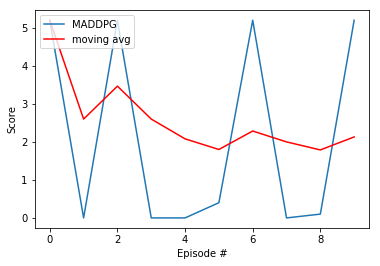

In [10]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='MADDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='moving avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

When finished, you can close the environment.

In [10]:
env.close()

---
## Failed Models (for reference)
The noise decay mechanism was setup incorrectly, so the noise decayed to zero too quickly (within ~20 episodes). 

In [9]:
# run the training loop

# GAMMA = 0.99            # discount factor
# TAU = 5e-2              # for soft update of target parameters
# OU_SIGMA = 0.2          # Ornstein-Uhlenbeck noise parameter, volatility
# OU_THETA = 0.15         # Ornstein-Uhlenbeck noise parameter, speed of mean reversion
# EPS = 2.0               # explore->exploit noise process added to act step
# EPS_DECAY = 4e-3        # decay rate for noise process

scores, avgs = maddpg()

Episodes 0000-0010	Max Reward: 0.000	Moving Average: 0.000
Episodes 0010-0020	Max Reward: 0.000	Moving Average: 0.000
Episodes 0020-0030	Max Reward: 0.000	Moving Average: 0.000
Episodes 0030-0040	Max Reward: 0.100	Moving Average: 0.003
Episodes 0040-0050	Max Reward: 0.100	Moving Average: 0.006
Episodes 0050-0060	Max Reward: 0.200	Moving Average: 0.012
Episodes 0060-0070	Max Reward: 0.100	Moving Average: 0.011
Episodes 0070-0080	Max Reward: 0.300	Moving Average: 0.016
Episodes 0080-0090	Max Reward: 0.000	Moving Average: 0.014
Episodes 0090-0100	Max Reward: 0.100	Moving Average: 0.018
Episodes 0100-0110	Max Reward: 0.100	Moving Average: 0.020
Episodes 0110-0120	Max Reward: 0.000	Moving Average: 0.020
Episodes 0120-0130	Max Reward: 0.200	Moving Average: 0.023
Episodes 0130-0140	Max Reward: 0.100	Moving Average: 0.024
Episodes 0140-0150	Max Reward: 0.100	Moving Average: 0.024
Episodes 0150-0160	Max Reward: 0.200	Moving Average: 0.024
Episodes 0160-0170	Max Reward: 0.100	Moving Average: 0.0

Episodes 1390-1400	Max Reward: 0.100	Moving Average: 0.029
Episodes 1400-1410	Max Reward: 0.100	Moving Average: 0.030
Episodes 1410-1420	Max Reward: 0.000	Moving Average: 0.029
Episodes 1420-1430	Max Reward: 0.100	Moving Average: 0.028
Episodes 1430-1440	Max Reward: 0.100	Moving Average: 0.026
Episodes 1440-1450	Max Reward: 0.100	Moving Average: 0.025
Episodes 1450-1460	Max Reward: 0.200	Moving Average: 0.026
Episodes 1460-1470	Max Reward: 0.100	Moving Average: 0.026
Episodes 1470-1480	Max Reward: 0.100	Moving Average: 0.028
Episodes 1480-1490	Max Reward: 0.200	Moving Average: 0.030
Episodes 1490-1500	Max Reward: 0.100	Moving Average: 0.028
Episodes 1500-1510	Max Reward: 0.100	Moving Average: 0.027
Episodes 1510-1520	Max Reward: 0.100	Moving Average: 0.028
Episodes 1520-1530	Max Reward: 0.100	Moving Average: 0.025
Episodes 1530-1540	Max Reward: 0.100	Moving Average: 0.026
Episodes 1540-1550	Max Reward: 0.100	Moving Average: 0.026
Episodes 1550-1560	Max Reward: 0.100	Moving Average: 0.0

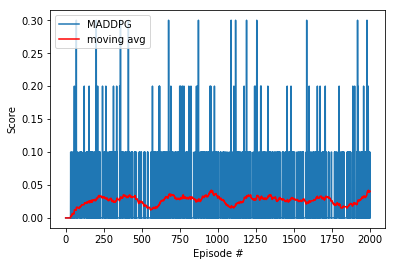

In [10]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='MADDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='moving avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

In [9]:
# run the training loop

# GAMMA = 0.99            # discount factor
# TAU = 1e-3              # for soft update of target parameters
# OU_SIGMA = 0.4          # Ornstein-Uhlenbeck noise parameter, volatility
# OU_THETA = 0.2          # Ornstein-Uhlenbeck noise parameter, speed of mean reversion
# EPS = 1.0               # explore->exploit noise process added to act step
# EPS_DECAY = 4e-3        # decay rate for noise process

scores, avgs = maddpg()

Episodes 0000-0010	Max Reward: 0.000	Moving Average: 0.000
Episodes 0010-0020	Max Reward: 0.000	Moving Average: 0.000
Episodes 0020-0030	Max Reward: 0.000	Moving Average: 0.000
Episodes 0030-0040	Max Reward: 0.100	Moving Average: 0.003
Episodes 0040-0050	Max Reward: 0.100	Moving Average: 0.006
Episodes 0050-0060	Max Reward: 0.200	Moving Average: 0.010
Episodes 0060-0070	Max Reward: 0.200	Moving Average: 0.013
Episodes 0070-0080	Max Reward: 0.100	Moving Average: 0.014
Episodes 0080-0090	Max Reward: 0.200	Moving Average: 0.018
Episodes 0090-0100	Max Reward: 0.200	Moving Average: 0.019
Episodes 0100-0110	Max Reward: 0.000	Moving Average: 0.019
Episodes 0110-0120	Max Reward: 0.100	Moving Average: 0.021
Episodes 0120-0130	Max Reward: 0.100	Moving Average: 0.023
Episodes 0130-0140	Max Reward: 0.000	Moving Average: 0.022
Episodes 0140-0150	Max Reward: 0.300	Moving Average: 0.026
Episodes 0150-0160	Max Reward: 0.200	Moving Average: 0.028
Episodes 0160-0170	Max Reward: 0.100	Moving Average: 0.0

Episodes 1390-1400	Max Reward: 0.100	Moving Average: 0.022
Episodes 1400-1410	Max Reward: 0.100	Moving Average: 0.021
Episodes 1410-1420	Max Reward: 0.200	Moving Average: 0.024
Episodes 1420-1430	Max Reward: 0.200	Moving Average: 0.025
Episodes 1430-1440	Max Reward: 0.100	Moving Average: 0.026
Episodes 1440-1450	Max Reward: 0.100	Moving Average: 0.027
Episodes 1450-1460	Max Reward: 0.100	Moving Average: 0.027
Episodes 1460-1470	Max Reward: 0.100	Moving Average: 0.026
Episodes 1470-1480	Max Reward: 0.100	Moving Average: 0.024
Episodes 1480-1490	Max Reward: 0.100	Moving Average: 0.024
Episodes 1490-1500	Max Reward: 0.100	Moving Average: 0.025
Episodes 1500-1510	Max Reward: 0.100	Moving Average: 0.027
Episodes 1510-1520	Max Reward: 0.100	Moving Average: 0.026
Episodes 1520-1530	Max Reward: 0.200	Moving Average: 0.025
Episodes 1530-1540	Max Reward: 0.200	Moving Average: 0.025
Episodes 1540-1550	Max Reward: 0.300	Moving Average: 0.028
Episodes 1550-1560	Max Reward: 0.100	Moving Average: 0.0

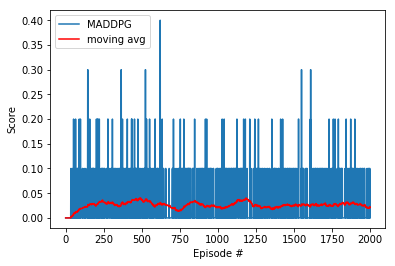

In [10]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='MADDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='moving avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()